In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import pandas as pd

In [8]:
# Load data
data = pd.read_csv('Close2AdmitDataWithRV.csv')

# Clean data
data = data.dropna(subset=['RV Dysfunction'])
data = data[data['RV Dysfunction'] != '0']

''' Select features
columns_to_exclude = ['patid', 'patkey', 'TTEDate', 'AVr_str', 'PVr_str', 'TVr_str', 'MVr_str']
'''

" Select features\ncolumns_to_exclude = ['patid', 'patkey', 'TTEDate', 'AVr_str', 'PVr_str', 'TVr_str', 'MVr_str']\n"

In [9]:
import numpy as np
import pandas as pd

def calculate_cardiac_indices(df):
    """
    Calculate cardiac indices based on available variables according to the provided formula sheet.
    
    Parameters:
    df (pandas.DataFrame): Input dataframe with RHC and TTE variables
    
    Returns:
    pandas.DataFrame: Dataframe with additional cardiac indices columns
    """
    # Convert LVIDd from mm to mL (assuming LVIDd is in mm, convert to cm, then use volume formula)
    df['LVIDd_cm'] = df['LVIDd'] / 10  # Convert mm to cm
    df['LVEDV'] = (4/3) * np.pi * (df['LVIDd_cm']/2) ** 3  # Volume calculation

    # Convert LVEF from percentage to fraction
    df['LVEF_tte'] = df['LVEF_tte'] * 0.01  

    # Calculate Left Ventricle Stroke Volume
    df['LVSV'] = df['LVEDV'] * df['LVEF_tte']

    # Mean Blood Pressure calculation
    df['mean_BP'] = (2/3 * df['NIBPd_vitals']) + (1/3 * df['NIBPs_vitals'])

    # Estimate Body Surface Area (BSA) using DuBois formula
    df['BSA'] = 0.007184 * (df['Weight'] ** 0.425) * (df['Height'] ** 0.725)

    # Left Ventricle Stroke Work Index (LVSWI)
    df['LVSWI'] = df['LVSV'] * (df['mean_BP'] - df['PCW']) * 0.0136 / df['BSA']

    # Right Ventricle Stroke Work Index (RVSWI)
    df['PAm'] = (df['PAs'] + 2 * df['PAd']) / 3
    df['RVSWI'] = df['LVSV'] * (df['PAm'] - df['RAm']) * 0.0136 / df['BSA']

    # LV Stiffness = stress / strain
    df['stress'] = df['PCW'] * (df['LVIDd_cm']/2) / (2 * df['IVSd'])
    df['strain'] = (df['LVIDd_cm'] - df['LVIDs']) / df['LVIDs']
    df['LV_stiffness'] = df['stress'] / df['strain']

    # Passive Cardiac Index = RAP * CO / (LVEDP * BSA), where LVEDP = PCW
    df['Passive_Cardiac_Index'] = df['RAm'] * df['CO_fick'] / (df['PCW'] * df['BSA'])

    return df


In [11]:
missing_percentages = data.isnull().mean() * 100
data = calculate_cardiac_indices(data)
#data = data.drop(columns=columns_to_exclude)
# Identify columns with more than 20% missing data
columns_to_drop = missing_percentages[missing_percentages > 20].index

# Drop these columns from the dataset
data = data.drop(columns=columns_to_drop)

# Display the columns dropped
print(f"Columns dropped: {columns_to_drop.tolist()}")

Columns dropped: []


In [12]:
#drop patients where more than 20% missing
missing_percentage = data.isnull().mean(axis=1)

# Keep only the rows where missing percentage is <= 0.2 (20%)
df_cleaned = data[missing_percentage <= 0.2]

# Reset index if desired
data = df_cleaned.reset_index(drop=True)

In [13]:
# Convert 'Birthday' to Age
if 'Birthday' in data.columns:
    data['Birthday'] = pd.to_datetime(data['Birthday'], format="%d-%b-%y", errors='coerce')
    data = data.dropna(subset=['Birthday'])  # Drop rows where Birthday conversion failed

    today = pd.to_datetime('today')
    data['Age'] = (today - data['Birthday']).dt.days / 365.25  

data = data.drop(columns=['Birthday'], errors='ignore')

# Select numerical features for X
X = data.select_dtypes(include=[np.number]).drop(columns=['RV Dysfunction'], errors='ignore')
print(X.head())


   Sex  Height  Weight  CO_td  CO_fick   PCW  PCWa  PCWv   PAs   PAd  ...  \
0    1   180.0    68.6   1.93     2.79  16.0  17.0  17.0  32.0  22.0  ...   
1    2   167.0    84.0   3.40     3.81  16.0  16.0  17.0  31.0  17.0  ...   
2    1   178.0   103.6   5.20     4.74  24.0   NaN  52.0  55.0  24.0  ...   
3    1   170.0    81.2   3.27     3.68  26.0  24.0  36.0  65.0  27.0  ...   
4    2   163.0    49.9   1.83     1.15  19.0  22.0  40.0  41.0  19.0  ...   

       LVSV    mean_BP       BSA     LVSWI        PAm     RVSWI    stress  \
0  0.331340  79.277778  1.870151  0.152471  25.333333  0.044175  3.000000   
1  0.482333  68.500000  1.930432  0.178398  21.666667  0.043042  4.250000   
2  0.577391  72.777778  2.210287  0.173294  34.333333  0.097108  4.472727   
3  0.248475  83.666667  1.927539  0.101098  39.666667  0.043244  8.450000   
4  0.179289  75.800000  1.520180  0.091106  26.333333  0.018178  4.195833   

     strain  LV_stiffness  Passive_Cardiac_Index  
0       NaN           N

In [14]:
# Pretty display all numerical features (first 5 rows)
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.precision', 2)       # Set decimal precision
X.head().style.set_caption("All Engineered Features (Sample)")\
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '12pt')]},
        {'selector': 'td', 'props': [('font-size', '11pt')]}
    ])


,Sex,Height,Weight,CO_td,CO_fick,PCW,PCWa,PCWv,PAs,PAd,RVs,RVmin,RVd,RAa,RAv,RAm,HR_vitals,HR_vitals_std,NIBPs_vitals,NIBPs_vitals_std,NIBPd_vitals,NIBPd_vitals_std,As,Ad,tteId,LVIDd,LVIDs,LVEF_tte,IVSd,LVPWd,LAd,AVr,AVpg,MVr,TVr,PVr,Age,patid,LVIDd_cm,LVEDV,LVSV,mean_BP,BSA,LVSWI,PAm,RVSWI,stress,strain,LV_stiffness,Passive_Cardiac_Index
0,1,180.000000,68.600000,1.930000,2.790000,16.000000,17.000000,17.000000,32.000000,22.000000,33.000000,6.000000,10.000000,9.000000,7.000000,7.000000,108.166667,38.644103,91.500000,2.428992,73.166667,3.656045,91.500000,73.166667,1,75,nan,0.001500,10,9.000000,43.000000,1.500000,4.000000,2.500000,1.500000,1.000000,48.000000,2.000000,7.500000,220.893233,0.331340,79.277778,1.870151,0.152471,25.333333,0.044175,3.000000,nan,nan,0.652688
1,2,167.000000,84.000000,3.400000,3.810000,16.000000,16.000000,17.000000,31.000000,17.000000,33.000000,8.000000,11.000000,11.000000,10.000000,9.000000,59.500000,0.707107,89.500000,7.778175,58.000000,2.828427,96.000000,63.000000,1,85,82.000000,0.001500,8,nan,59.000000,2.000000,6.000000,2.500000,2.000000,1.000000,63.000000,4.000000,8.500000,321.555098,0.482333,68.500000,1.930432,0.178398,21.666667,0.043042,4.250000,-0.896341,-4.741497,1.110179
2,1,178.000000,103.600000,5.200000,4.740000,24.000000,nan,52.000000,55.000000,24.000000,57.000000,7.000000,10.000000,nan,nan,7.000000,71.333333,4.041452,94.333333,3.214550,62.000000,2.645751,94.333333,62.000000,1,82,75.000000,0.002000,11,11.000000,73.000000,1.000000,7.000000,4.000000,3.000000,1.000000,71.000000,5.000000,8.200000,288.695610,0.577391,72.777778,2.210287,0.173294,34.333333,0.097108,4.472727,-0.890667,-5.021775,0.625484
3,1,170.000000,81.200000,3.270000,3.680000,26.000000,24.000000,36.000000,65.000000,27.000000,70.000000,7.000000,19.000000,25.000000,18.000000,15.000000,79.000000,4.242641,111.000000,8.485281,70.000000,4.242641,96.000000,63.000000,1,78,69.000000,0.001000,6,7.000000,65.000000,1.000000,nan,3.500000,2.000000,2.000000,56.000000,6.000000,7.800000,248.474846,0.248475,83.666667,1.927539,0.101098,39.666667,0.043244,8.450000,-0.886957,-9.526961,1.101445
4,2,163.000000,49.900000,1.830000,1.150000,19.000000,22.000000,40.000000,41.000000,19.000000,45.000000,11.000000,16.000000,20.000000,22.000000,15.000000,99.600000,19.007893,89.000000,4.636809,69.200000,5.585696,89.000000,69.200000,5,53,45.000000,0.002300,6,7.000000,38.000000,1.500000,9.000000,3.500000,3.000000,1.500000,45.000000,9.000000,5.300000,77.951815,0.179289,75.800000,1.520180,0.091106,26.333333,0.018178,4.195833,-0.882222,-4.755982,0.597228


In [15]:
from sklearn.impute import KNNImputer
# Initialize the KNN imputer
# You can adjust n_neighbors as needed
X = X.replace([np.inf, -np.inf], np.nan)

knn_imputer = KNNImputer(n_neighbors=5)

# Get the feature names for later use
feature_names = X.columns

# Apply KNN imputation to your features
X_imputed = knn_imputer.fit_transform(X)

# Convert back to DataFrame to preserve column names
X = pd.DataFrame(X_imputed, columns=feature_names)

# Then continue with standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
# Encode target variable into binary labels
Y = data['RV Dysfunction'].replace({
    'Moderate': 'High Dysfunction',
    'Severe': 'High Dysfunction',
    'Normal': 'Low Dysfunction',
    'Mild': 'Low Dysfunction'
})

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=42)


In [17]:
print("Class distribution:", np.bincount(y_train))
print("Classes",np.unique(Y) )

Class distribution: [131 219]
Classes ['High Dysfunction' 'Low Dysfunction']


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

def train_and_evaluate(model, model_name, X_train, Y_train, X_test, Y_test):
    """
    Trains and evaluates a classification model.
    Displays classification report as a table, confusion matrix as a heatmap, and calculates ROC AUC.
    """
    print(f"\n--- {model_name} ---")

    # Train the model
    model.fit(X_train, Y_train)

    # Make predictions
    Y_pred = model.predict(X_test)

    # Generate classification report dictionary
    report = classification_report(Y_test, Y_pred, output_dict=True)

    # Convert report to DataFrame
    report_df = pd.DataFrame(report).transpose()

    # Display classification report as a table
    print("\nClassification Report:")
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis("tight")
    ax.axis("off")
    table = ax.table(cellText=report_df.round(2).values, 
                     colLabels=report_df.columns, 
                     rowLabels=report_df.index, 
                     cellLoc="center", 
                     loc="center")
    plt.show()

    # Print and plot confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(Y_test, Y_pred)
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Calculate and plot ROC AUC if applicable
    if hasattr(model, "predict_proba"):
        Y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(Y_test, Y_pred_proba)

        print(f"ROC AUC: {roc_auc:.4f}")

        fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
    
    return model


In [19]:
def tune_hyperparameters_with_feature_selection(X_train, y_train, selected_features, n_iter=20, cv=5, random_state=42):
    """
    Tunes hyperparameters for a Random Forest classifier using RandomizedSearchCV,
    using only the selected features from feature selection.
    
    Parameters:
    - X_train: Training feature matrix.
    - y_train: Training labels.
    - selected_features: List of column names for selected features.
    - n_iter: Number of random parameter sets to try (default: 20).
    - cv: Number of cross-validation folds (default: 5).
    - random_state: Random seed for reproducibility (default: 42).
    
    Returns:
    - best_model: The trained Random Forest model with the best hyperparameters.
    - best_params: The best hyperparameter combination found.
    """
    
    # Define the hyperparameter search space
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'min_samples_split': [2, 3, 5, 7, 10, 15, 20],
        'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'max_features': [None, 'sqrt', 'log2'],
        'bootstrap': [True, False],
    }
    
    # Initialize the Random Forest classifier
    rf = RandomForestClassifier(random_state=random_state)
    
    # Perform Randomized Search with Cross-Validation
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring='roc_auc',
        random_state=random_state,
        n_jobs=-1,
        error_score='raise'
    )
    
    # Fit the model using only the selected features
    # Note: X_train should already be transformed using the selector
    random_search.fit(X_train, y_train)
    
    # Extract the best model and parameters
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    return best_model, best_params

In [20]:
# Train a Random Forest model to get feature importances
initial_rf = RandomForestClassifier(random_state=42)
initial_rf.fit(X_train, y_train)

# Use SelectFromModel to select features based on the mean importance
selector = SelectFromModel(initial_rf, threshold="mean", prefit=True)

# Transform the training and testing datasets based on the selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Get the selected feature names using get_support()
selected_indices = selector.get_support()
selected_features = [feature_names[i] for i in range(len(feature_names)) if selected_indices[i]]

# Print the actual selected feature names
print("Selected Features:", selected_features)

Selected Features: ['Weight', 'CO_fick', 'PCWa', 'PCWv', 'PAs', 'RVs', 'RVd', 'RAa', 'RAv', 'RAm', 'HR_vitals', 'NIBPs_vitals_std', 'NIBPd_vitals_std', 'As', 'LAd', 'AVpg', 'Age', 'patid', 'LVSV', 'LVSWI', 'PAm', 'RVSWI', 'stress', 'strain', 'LV_stiffness', 'Passive_Cardiac_Index']



--- Random Forest with Feature Selection ---

Classification Report:


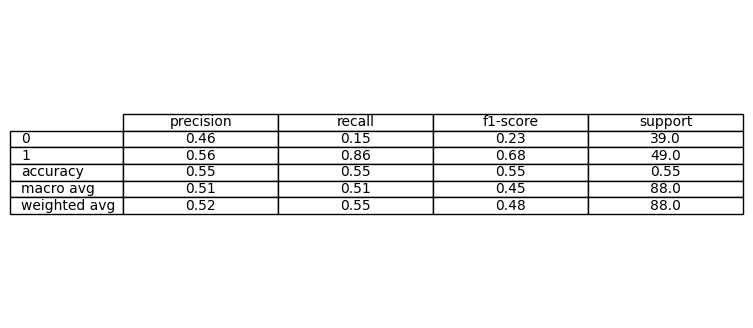


Confusion Matrix:


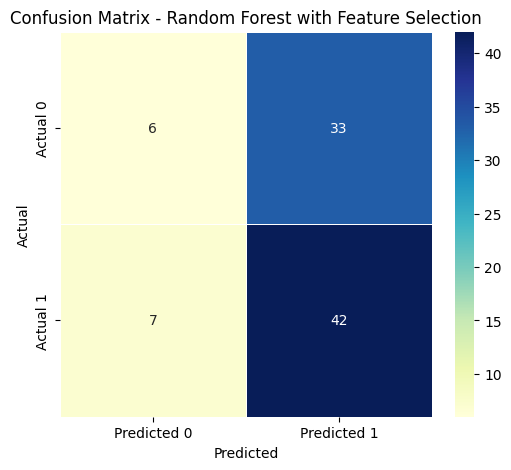

ROC AUC: 0.4696


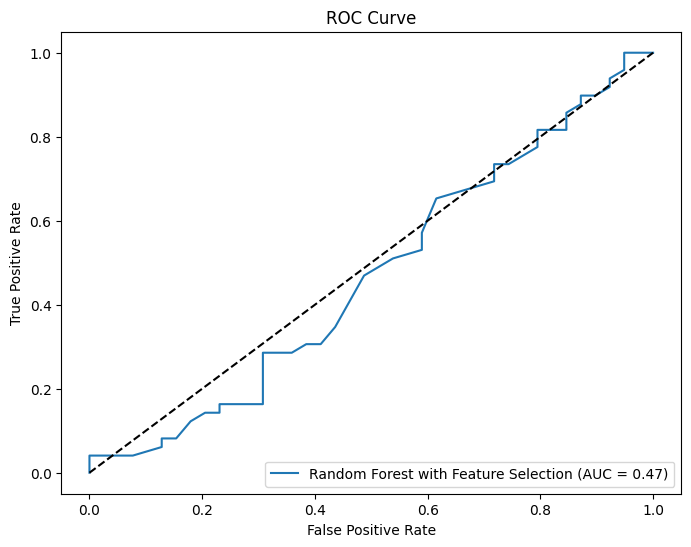

In [21]:
rf_selected = RandomForestClassifier(random_state=42)
default_model = train_and_evaluate(rf_selected, "Random Forest with Feature Selection", 
                                  X_train_selected, y_train, X_test_selected, y_test)


In [22]:
# Tune hyperparameters on the selected features
best_model, best_params = tune_hyperparameters_with_feature_selection(
    X_train_selected, y_train, selected_features)

# Print the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Best Hyperparameters:
n_estimators: 300
min_samples_split: 15
min_samples_leaf: 8
max_features: log2
max_depth: 70
bootstrap: True



--- Tuned Random Forest with Feature Selection ---

Classification Report:


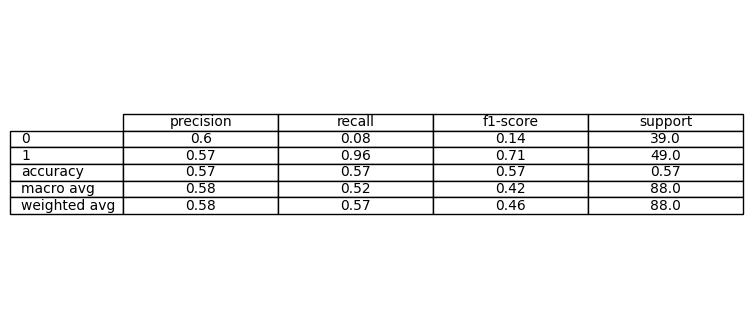


Confusion Matrix:


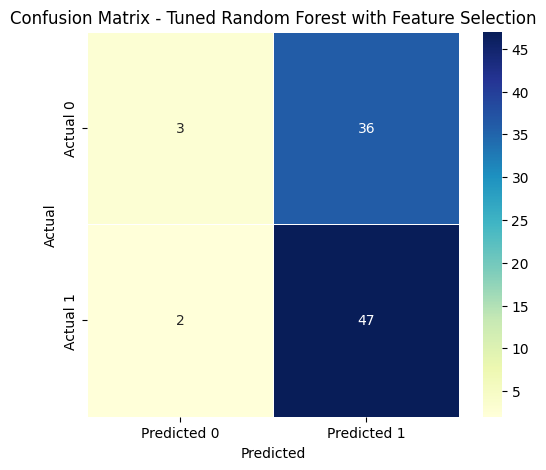

ROC AUC: 0.5275


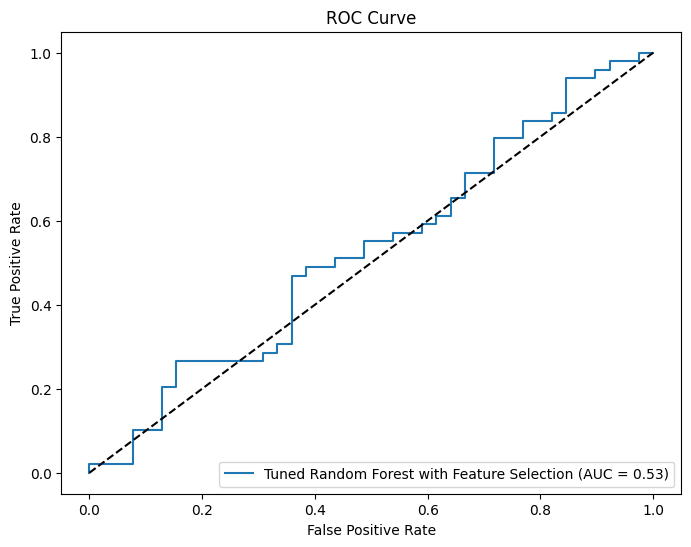

In [23]:
# Train and evaluate the Random Forest model with tuned hyperparameters on selected features
tuned_model = train_and_evaluate(best_model, "Tuned Random Forest with Feature Selection", 
                               X_train_selected, y_train, X_test_selected, y_test)


In [24]:
def plot_feature_importance(model, feature_names, title="Feature Importance", top_n=20, top_n_true=False):
    """
    Plot feature importance from a Random Forest model.
    
    Parameters:
    - model: Trained Random Forest model
    - feature_names: List of feature names
    - title: Plot title
    - top_n: Number of top features to display
    - top_n_true: Whether to display only top_n features
    """
    # Get feature importance from the model
    importances = model.feature_importances_
    
    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,  # These should already be actual feature names
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # If displaying top_n features, limit the DataFrame to the top_n features
    if top_n_true:
        feature_importance_df = feature_importance_df.head(top_n)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(title)
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    
    # Rotate the y-axis labels for better readability
    plt.yticks(rotation=0)  # Set rotation to 0 or adjust as needed
    
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df


Feature Importance for Default Random Forest:


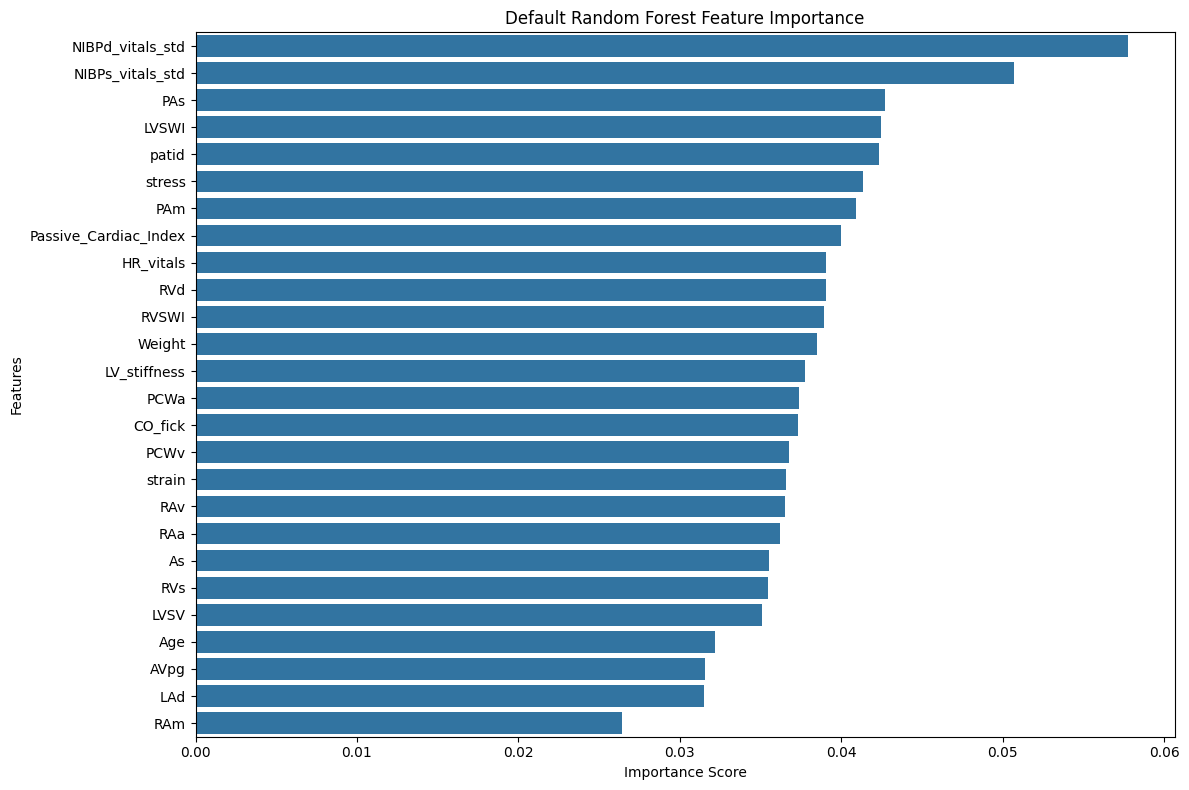


Feature Importance for Tuned Random Forest:


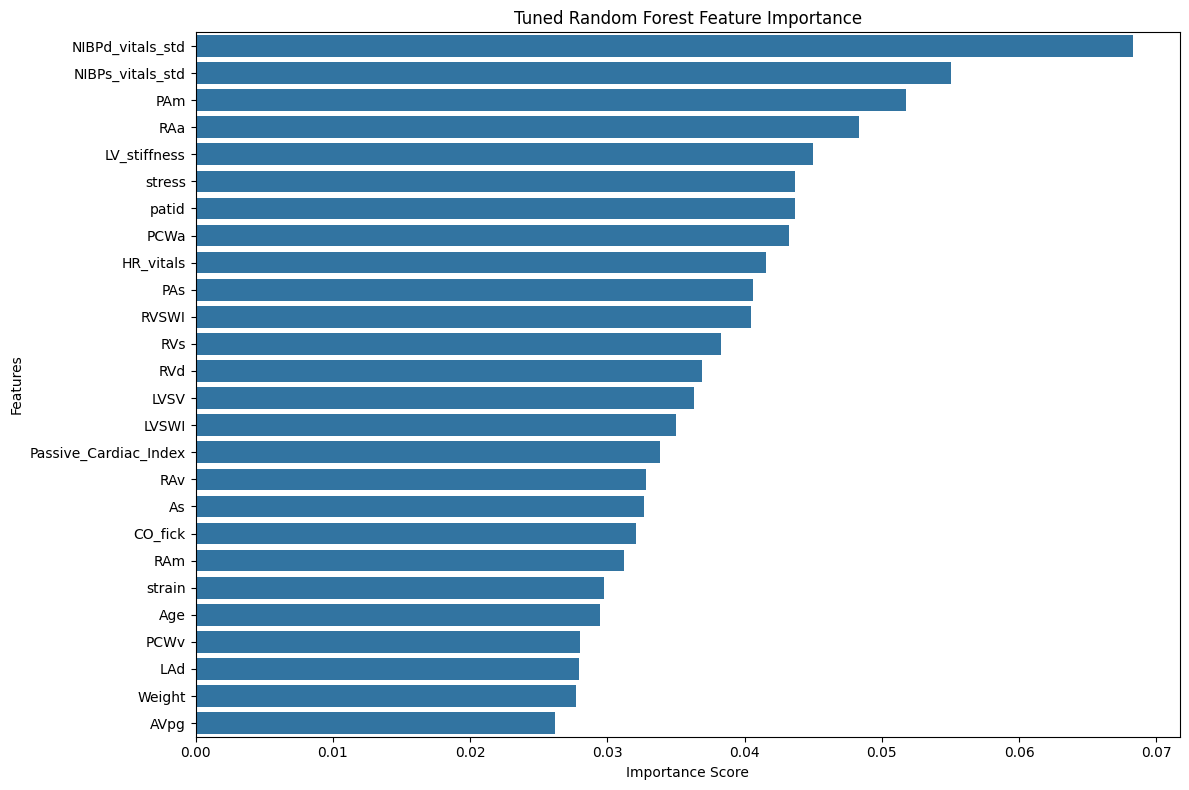


Feature Importance for Default Random Forest (Top 10):


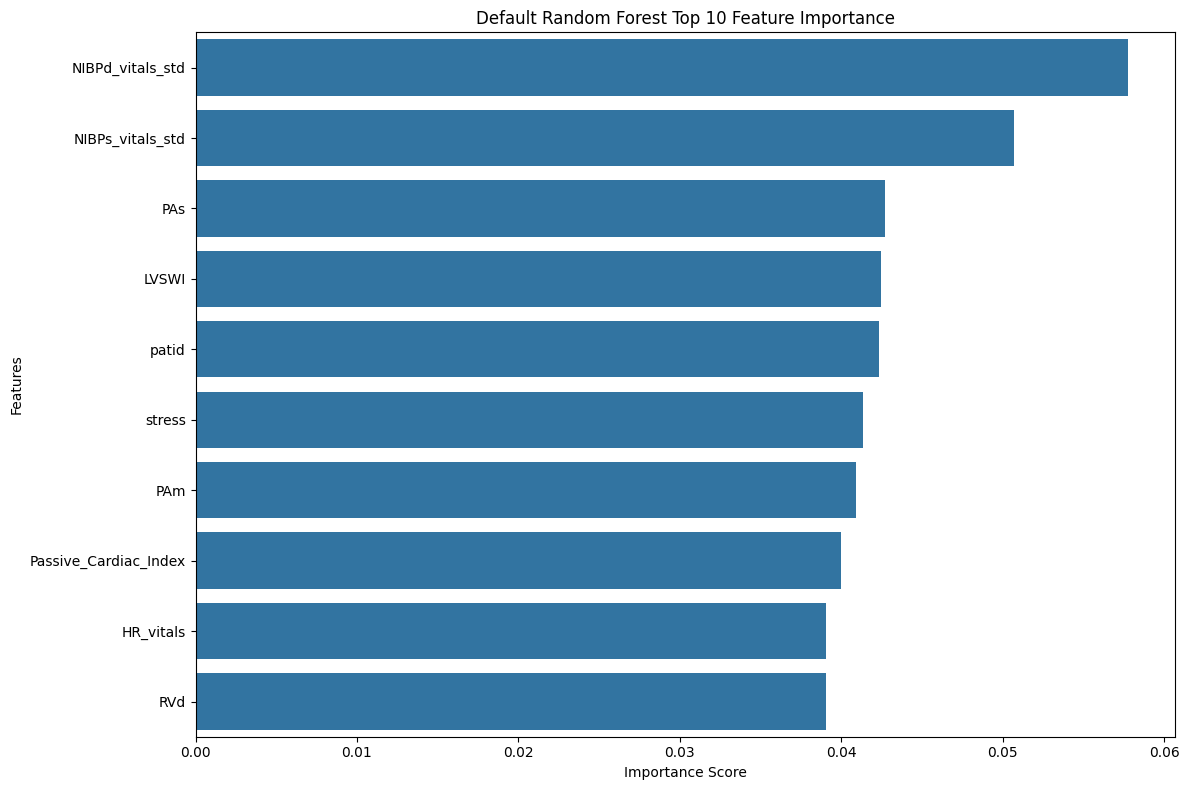


Feature Importance for Tuned Random Forest (Top 10):


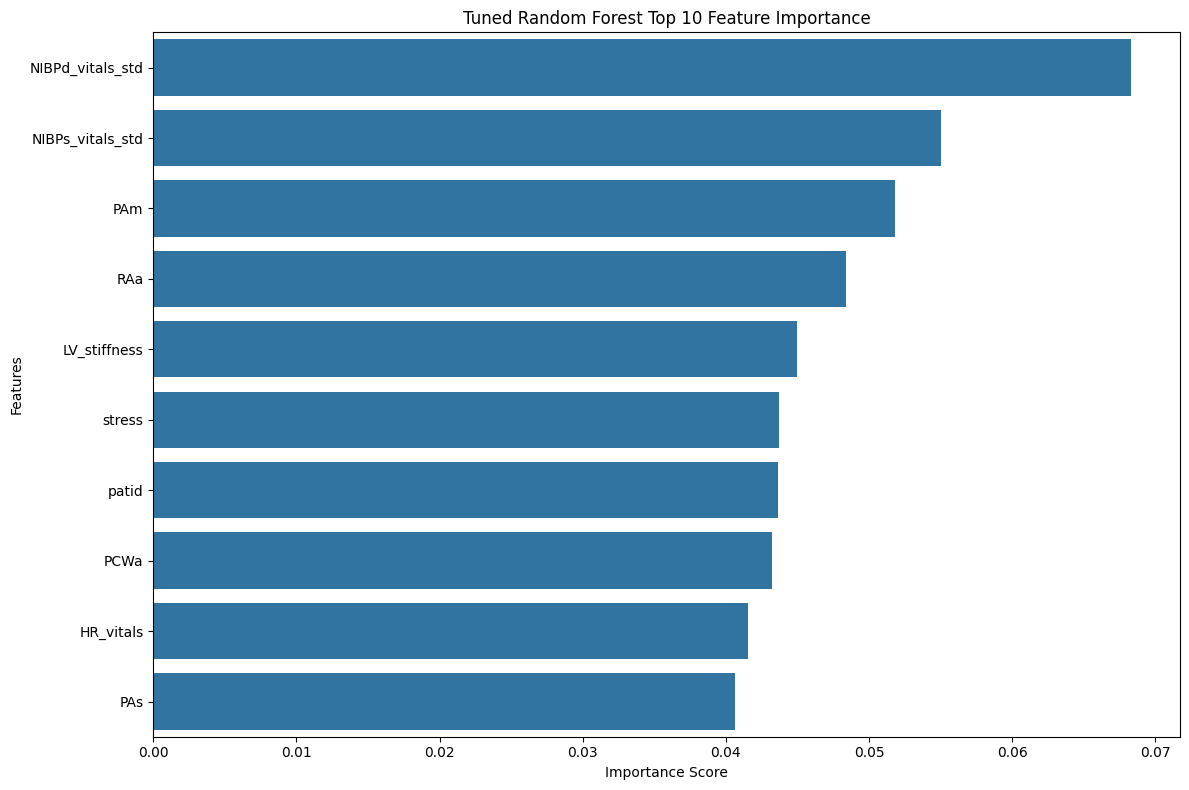

In [25]:
# Plot feature importance for both models
print("\nFeature Importance for Default Random Forest:")
importance_df_default = plot_feature_importance(default_model, selected_features, 
                                              "Default Random Forest Feature Importance")

print("\nFeature Importance for Tuned Random Forest:")
importance_df_tuned = plot_feature_importance(tuned_model, selected_features, 
                                            "Tuned Random Forest Feature Importance")

# For top 20 features
print("\nFeature Importance for Default Random Forest (Top 10):")
importance_df_default = plot_feature_importance(default_model, selected_features, 
                                             "Default Random Forest Top 10 Feature Importance", 10, True)
print("\nFeature Importance for Tuned Random Forest (Top 10):")
importance_df_tuned = plot_feature_importance(tuned_model, selected_features, 
                                           "Tuned Random Forest Top 10 Feature Importance", 10, True)